## Mã hóa hướng dẫn có mục tiêu

Trong các bài giảng trước của phần này, chúng ta đã học cách chuyển đổi nhãn thành một số bằng mã hóa one-hot, thay thế bằng một chữ số, thay thế bằng tần suất hoặc số lượng quan sát. Các phương pháp này rất đơn giản, hầu như không có giả định và nhìn chung hoạt động tốt trong các tình huống khác nhau.

Tuy nhiên, cũng có những phương pháp cho phép chúng ta nắm bắt thông tin trong khi tiền xử lý nhãn của các biến hạng mục. Các phương pháp đó gồm:

- Sắp xếp các nhãn theo mục tiêu.
- Thay thế các nhãn bằng giá trị trung bình mục tiêu (mã hóa mean/mã hóa mục tiêu).
- Thay thế các nhãn theo tỷ lệ xác suất của mục tiêu là 1 hoặc 0.
- Trọng số bằng chứng.

Tất cả các phương pháp trên đều có điểm chung là:

- Mã hóa được **hướng dẫn bởi mục tiêu** và
- Tạo ra **mối quan hệ đơn điệu** giữa biến và mục tiêu.


### Tính đơn điệu

Mối quan hệ đơn điệu là mối quan hệ thực hiện một trong những điều sau:

- (1) khi giá trị của một biến tăng lên thì giá trị của biến kia cũng vậy; hoặc
- (2) khi giá trị của một biến tăng, giá trị của biến kia lại giảm.

Trong trường hợp này, khi giá trị của biến độc lập (yếu tố dự báo) tăng lên, thì mục tiêu cũng vậy; hoặc ngược lại, khi giá trị của biến tăng lên thì giá trị mục tiêu lại giảm.



### Ưu điểm của mã hóa hướng dẫn có mục tiêu

- Nắm bắt thông tin trong hạng mục nên tạo ra nhiều đặc trưng dự đoán hơn.
- Tạo mối quan hệ đơn điệu giữa biến và mục tiêu để phù hợp với mô hình tuyến tính.
- Không mở rộng không gian đặc trưng.


### Hạn chế

- Dễ dẫn tới overfitting.
- Khó kiểm định chéo với các thư viện hiện tại.


### Lưu ý

Các phương pháp được thảo luận trong bài này và 3 bài giảng sắp tới cũng có thể sử dụng với các biến dạng số sau khi thực hiện rời rạc hóa. Điều này tạo ra mối quan hệ đơn điệu giữa biến dạng số và mục tiêu, do đó cải thiện chất lượng của mô hình tuyến tính.

===============================================================================

## Mã hóa tỷ lệ xác suất

Mã hóa này chỉ thích hợp với các bài toán phân loại có biến nhị phân.

Với từng hạng mục, chúng ta tính mean của target=1 là xác suất của mục tiêu là 1 ( P(1) ), và xác suất của target=0 ( P(0) ). Sau đó, chúng ta tính tỷ lệ P(1)/P(0) và thay thế các hạng mục bằng tỷ lệ đó.


## Trong bản mô phỏng này:

Chúng ta sẽ thực hiện mã hóa với:
- pandas
- Feature-Engine

Chúng ta sẽ sử dụng tập dữ liệu Titanic để minh họa các ưu điểm và hạn chế của từng triển khai.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

# chia tập dữ liệu
from sklearn.model_selection import train_test_split

# mã hóa với feature-engine
from feature_engine.encoding import PRatioEncoder

import warnings
warnings.filterwarnings('ignore')

In [2]:
data_path = 'D:\\FUNix\\04. Machine Learning\\04.2. MLP302x - Regresssion\\dataset'

In [3]:
# load tập dữ liệu

data = pd.read_csv(
    data_path + '/titanic.csv',
    usecols=['cabin', 'sex', 'embarked', 'survived'])

data.head()

,survived,sex,cabin,embarked
0,1,female,B5,S
1,1,male,C22,S
2,0,female,C22,S
3,0,male,C22,S
4,0,female,C22,S


In [4]:
# loại bỏ các quan sát có na trong embarked

data.dropna(subset=['embarked'], inplace=True)
data.shape

(1307, 4)

In [5]:
# trích xuất chữ cái đầu của cabin
# để tạo biến đơn giản hơn cho mô phỏng

data['cabin'] = data['cabin'].astype(str).str[0]

In [6]:
# và loại bỏ các quan sát có cabin = T
# vì chúng quá ít

data = data[data['cabin']!= 'T']
data.shape

(1306, 4)

In [7]:
# xem từng biến có bao nhiêu nhãn

for col in data.columns:
    print(col, ': ', len(data[col].unique()), ' labels')

survived :  2  labels
sex :  2  labels
cabin :  8  labels
embarked :  3  labels


In [ ]:
# khám phá các hạng mục duy nhất
data['cabin'].unique()

array(['B', 'C', 'E', 'D', 'A', 'n', 'F', 'G'], dtype=object)

In [ ]:
data['sex'].unique()

array(['female', 'male'], dtype=object)

In [ ]:
data['embarked'].unique()

array(['S', 'C', 'Q'], dtype=object)

### Mã hóa quan trọng

Chúng ta cần tính tỷ lệ P(1)/P(0) sử dụng tập huấn luyện, sau đó sử dụng các mapping đó trong tập kiểm tra.

Lưu ý với triển khai này của pandas, chúng ta cần giữ mục tiêu trong tập huấn luyện.

In [8]:
# hãy chia thành tập huấn luyện và tập kiểm tra

X_train, X_test, y_train, y_test = train_test_split(
    data[['cabin', 'sex', 'embarked', 'survived']],  # lần này giữ mục tiêu!!
    data['survived'],  # mục tiêu
    test_size=0.3,  # phần trăm các quan sát trong tập kiểm tra
    random_state=0)  # seed đảm bảo khả năng tái lặp

X_train.shape, X_test.shape

((914, 4), (392, 4))

### Khám phá mối quan hệ ban đầu giữa biến hạng mục với mục tiêu

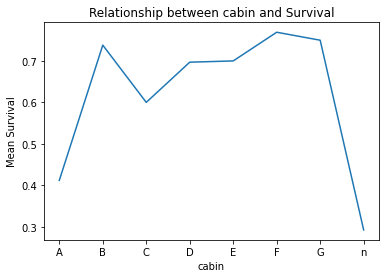

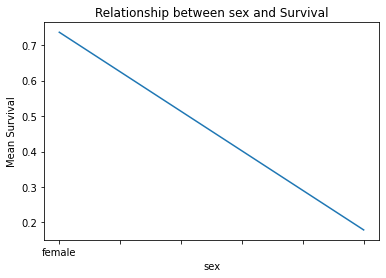

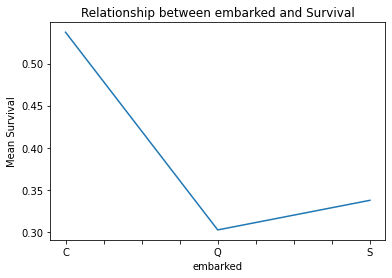

In [9]:
# khám phá mối quan hệ của các hạng mục với mục tiêu

for var in ['cabin', 'sex', 'embarked']:
    
    fig = plt.figure()
    fig = X_train.groupby([var])['survived'].mean().plot()
    fig.set_title('Relationship between {} and Survival'.format(var))
    fig.set_ylabel('Mean Survival')
    plt.show()

Chúng ta thấy mối quan hệ giữa mục tiêu, cabin và embarked tăng và giảm phụ thuộc vào hạng mục.


## Mã hóa tỷ lệ xác suất với pandas


### Ưu điểm

- nhanh
- trả về pandas dataframe

### Hạn chế của pandas:

- Nó không bảo toàn thông tin từ dữ liệu huấn luyện để truyền sang dữ liệu kiểm tra.

In [11]:
## Yêu cầu 1: tính xác suất survived =1 trên mỗi hạng mục

## VIẾT CODE Ở ĐÂY:
prob_df = X_train.groupby(['cabin'])['survived'].mean()

# và ghi nó vào dataframe
## VIẾT CODE Ở ĐÂY:
prob_df = pd.DataFrame(prob_df)
prob_df

,survived
cabin,
A,0.411765
B,0.738095
C,0.600000
D,0.696970
E,0.700000
F,0.769231
G,0.750000
n,0.292199


<details><summary> Gợi ý </summary>

[mean()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.mean.html)

</details>

In [12]:
## Yêu cầu 2
# giờ xác suất của survived = 0

## VIẾT CODE Ở ĐÂY:
prob_df['died'] = 1 - prob_df['survived']

prob_df

,survived,died
cabin,,
A,0.411765,0.588235
B,0.738095,0.261905
C,0.600000,0.400000
D,0.696970,0.303030
E,0.700000,0.300000
F,0.769231,0.230769
G,0.750000,0.250000
n,0.292199,0.707801


In [13]:
## Yêu cầu 3: tính tỷ lệ

## VIẾT CODE Ở ĐÂY:
prob_df['ratio'] = prob_df['survived'] / prob_df['died']

prob_df

,survived,died,ratio
cabin,,,
A,0.411765,0.588235,0.700000
B,0.738095,0.261905,2.818182
C,0.600000,0.400000,1.500000
D,0.696970,0.303030,2.300000
E,0.700000,0.300000,2.333333
F,0.769231,0.230769,3.333333
G,0.750000,0.250000,3.000000
n,0.292199,0.707801,0.412826


In [14]:
## Yêu cầu 4: ghi lại tỷ lệ trong một dictionary

## VIẾT CODE Ở ĐÂY:
ordered_labels = prob_df['ratio'].to_dict()

ordered_labels

{'A': 0.7,
 'B': 2.818181818181819,
 'C': 1.4999999999999998,
 'D': 2.3000000000000007,
 'E': 2.333333333333333,
 'F': 3.333333333333334,
 'G': 3.0,
 'n': 0.4128256513026052}

<details><summary> Gợi ý </summary>

[to_dict()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.to_dict.html)

</details>

In [15]:
## Yêu cầu 5: thay thế các nhãn với tỷ lệ

## VIẾT CODE Ở ĐÂY:
X_train['cabin'] = X_train['cabin'].map(ordered_labels)
X_test['cabin'] = X_test['cabin'].map(ordered_labels)

In [16]:
# khám phá kết quả

X_train['cabin'].head(10)

843     0.412826
869     0.412826
430     0.412826
481     0.412826
1308    0.412826
456     0.412826
118     2.300000
485     2.300000
297     0.412826
263     2.333333
Name: cabin, dtype: float64

In [17]:
## Yêu cầu 6: biến các lệnh trước đó thành 2 hàm


def find_category_mappings(df, variable, target):

    ## VIẾT CODE Ở ĐÂY:
    tmp = pd.DataFrame(df.groupby([variable])[target].mean())
    
    tmp['non-target'] = 1 - tmp[target]
    
    tmp['ratio'] = tmp[target] / tmp['non-target']

    return tmp['ratio'].to_dict()


def integer_encode(train, test, variable, ordinal_mapping):
    ## VIẾT CODE Ở ĐÂY:
    train[variable] = train[variable].map(ordinal_mapping)
    test[variable] = test[variable].map(ordinal_mapping)

In [19]:
## Yêu cầu 7: chạy một vòng lặp qua các biến hạng mục còn lại

for variable in ['sex', 'embarked']:
    ## VIẾT CODE Ở ĐÂY:
    mappings = find_category_mappings(X_train, variable, 'survived')
    ## VIẾT CODE Ở ĐÂY:
    integer_encode(X_train, X_test, variable, mappings)

In [20]:
# hãy xem kết quả

X_train.head()

,cabin,sex,embarked,survived
843,0.412826,0.218107,0.509434,0
869,0.412826,0.218107,0.509434,0
430,0.412826,2.788235,0.509434,1
481,0.412826,2.788235,1.160920,1
1308,0.412826,0.218107,0.509434,0


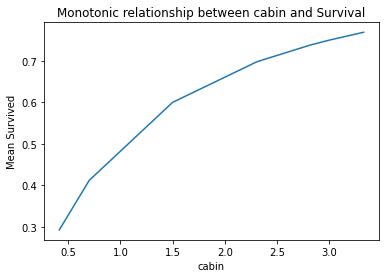

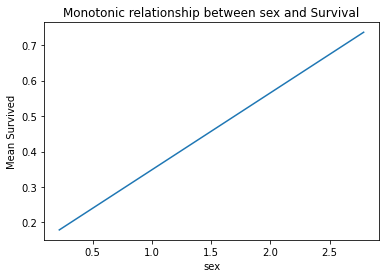

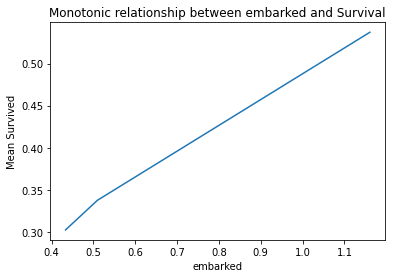

In [21]:
# kiểm tra mối quan hệ đơn điệu mới tạo
# giữa các biến hạng mục và mục tiêu

for var in ['cabin', 'sex', 'embarked']:
    
    fig = plt.figure()
    fig = X_train.groupby([var])['survived'].mean().plot()
    fig.set_title('Monotonic relationship between {} and Survival'.format(var))
    fig.set_ylabel('Mean Survived')
    plt.show()

Lưu ý mối quan hệ đơn điệu giữa mục tiêu trung bình và các hạng mục.

### Lưu ý

Việc thay thế các nhãn hạng mục với phương pháp và code này sẽ tạo ra các giá trị bị khuyết cho các hạng mục có trong tập kiểm tra mà không thấy trong tập huấn luyện. Do đó, việc xử lý nhãn hiếm trước khi thực hiện vô cùng quan trọng. Chúng ta sẽ giải thích cách làm điều này trong notebook sau.

**Ngoài ra, nó sẽ tạo NA hoặc Inf nếu xác suất của target = 0 là 0 vì phép chia cho 0 không xác định.**

## Mã hóa tỷ lệ xác suất với Feature-Engine

Chúng ta sẽ không giữ được biến mục tiêu trong tập huấn luyện nếu sử dụng Feature-Engine thay vì pandas.

In [23]:
# hãy chia thành tập huấn luyện và tập kiểm tra

X_train, X_test, y_train, y_test = train_test_split(
    data[['cabin', 'sex', 'embarked']], # các yếu tố dự báo
    data['survived'],  # mục tiêu
    test_size=0.3,  # phần trăm các quan sát trong tập kiểm tra
    random_state=0)  # seed đảm bảo khả năng tái lặp

X_train.shape, X_test.shape

((914, 3), (392, 3))

In [24]:
ratio_enc = PRatioEncoder(
    encoding_method = 'ratio',
    variables=['cabin', 'sex', 'embarked'])

In [25]:
# khi khớp transformer, chúng ta cũng cần truyền mục tiêu
# giống như bất kì class dự báo nào của Scikit-learn

ratio_enc.fit(X_train, y_train)

PRatioEncoder(variables=['cabin', 'sex', 'embarked'])

In [26]:
# trong dict encoder, chúng ta thấy P(1)/P(0) cho từng
# hạng mục cho mỗi biến đã chỉ ra

ratio_enc.encoder_dict_

{'cabin': {'A': 0.7,
  'B': 2.818181818181819,
  'C': 1.4999999999999998,
  'D': 2.3000000000000007,
  'E': 2.333333333333333,
  'F': 3.333333333333334,
  'G': 3.0,
  'n': 0.4128256513026052},
 'sex': {'female': 2.788235294117647, 'male': 0.21810699588477367},
 'embarked': {'C': 1.160919540229885,
  'Q': 0.4333333333333333,
  'S': 0.5094339622641509}}

In [27]:
# đây là list các biến mà encoder sẽ biến đổi

ratio_enc.variables_

['cabin', 'sex', 'embarked']

In [28]:
X_train = ratio_enc.transform(X_train)
X_test = ratio_enc.transform(X_test)

# khám phá kết quả
X_train.head()

,cabin,sex,embarked
843,0.412826,0.218107,0.509434
869,0.412826,0.218107,0.509434
430,0.412826,2.788235,0.509434
481,0.412826,2.788235,1.160920
1308,0.412826,0.218107,0.509434


**Lưu ý**

Nếu các biến đối số được để thành None thì encoder sẽ tự động xác định tất cả các biến hạng mục. Tuyệt đúng không?

Encoder sẽ không mã hóa các biến dạng số. Vì vậy, nếu một số biến dạng số là biến hạng mục thì chúng ta sẽ cần ép kiểu lại chúng thành object trước khi sử dụng encoder.

Nếu có một nhãn trong tập kiểm tra mà không xuất hiện trong tập huấn luyện thì encoder sẽ thông qua và báo lỗi để cảnh báo về động thái này.

Cuối cùng, nếu xác suất của target=0 là 0 cho bất kỳ hạng mục nào thì encoder sẽ nêu lỗi do phép chia cho 0 không xác định. 

==============================End================================